In [1]:
import pickle

# open a file, where you ant to store the data
with open('./processed.pickle', 'rb') as processed_file:

    # dump information to that file
    requests = pickle.load(processed_file)

# open a file, where you ant to store the data
with open('./processed_new.pickle', 'rb') as processed_new_file:

    # dump information to that file
    requests_new = pickle.load(processed_new_file)


# # open a file, where you ant to store the data
# with open('./processed_new_new.pickle', 'rb') as processed_new_new_file:

#     # dump information to that file
#     requests_new_new = pickle.load(processed_new_new_file)


requests["positive"] += requests_new["positive"]
requests["negative"] += requests_new["negative"]

# requests["positive"] += requests_new_new["positive"]
# requests["negative"] += requests_new_new["negative"]


## Analyze tags

In [2]:
from torch.nn import functional as F

def get_dist(type, idx, upper=50, lower=-2, output_probs=False):
    if output_probs:
        values = F.softmax(requests[type][idx][2], dim=-1)
    else:
        values = requests[type][idx][2]
        
    values = values.tolist()
    
    return [min(upper, max(lower, v)) for v in values]

## Visualize

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mplcursors import cursor

# Plotting
def plot(type, idx, output_probs=False):
    dist = get_dist(type, idx, output_probs=output_probs)

    plt.clf()
    plt.figure(figsize=(15, 6))
    plt.plot(dist, marker='o', linestyle='-', color='blue')
    plt.title(f'Plot of result {idx}')
    plt.xlabel('Index')
    plt.ylabel('Logit')
    
    # Highlighting tags
    # b : blue · g : green · r : red · c : cyan · m : magenta · y : yellow · k : black
    colors = "b,g,r,c,m,y,k".split(',')
    
    for (tag, id), color in zip(tag_id_map.items(), colors):
        plt.axvline(x=id, color=color, linestyle='--', label=tag)  # Indices are 0-based

    # Dotted horizontal line on zero
    plt.axhline(y=0, color='y', linestyle=':', label='y=0 Line')

    plt.legend()
    cursor(hover=True)

    plt.show()



In [4]:
%matplotlib widget
show = lambda type, idx, output_probs=False: (requests[type][idx][0], plot(type, idx, output_probs))

### Positive samples
> (where a function should be called)

In [5]:
import ipywidgets as wg

# wg.interact(show, type="positive", idx=wg.IntSlider(min=0, max=len(requests["positive"])-1, step=1))

### Negative samples
> (where functions should NOT be called)

In [6]:
# wg.interact(show, type="negative", idx=wg.IntSlider(min=0, max=len(requests["negative"])-1, step=1))

In [7]:
from transformers import AutoTokenizer

model_name = "julep-ai/samantha-1-turbo"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
# List of tags 
allowed_tags = ["me", "function_call", "thought"]
disallowed_tags = ["situation", "person", "functions", "information"]
tags = allowed_tags + disallowed_tags

allowed_tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in allowed_tags
]

disallowed_tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in disallowed_tags
]

tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in tags
]

tag_id_map = {
    tag: tag_ids[0]
    for tag, tag_ids in zip(tags, tag_token_ids)
}

id_tag_map = {
    id: tag
    for tag, id in tag_id_map.items()
}

In [9]:
get_points = lambda type, select_tags, limit=-1: [
    req[2].tolist()
    if select_tags is None
    else [
        req[2][tag_id_map[tag]].item()
        for tag in select_tags
    ]
    for req in requests[type][:limit]
]

In [10]:
positive_points = get_points("positive", ["me", "function_call"])
negative_points = get_points("negative", ["me", "function_call"])

positive_xs, positive_ys = zip(*positive_points)
negative_xs, negative_ys = zip(*negative_points)

xs = negative_xs + positive_xs
ys = negative_ys + positive_ys
colors = ['r']*len(negative_xs) + ['b']*len(positive_xs)


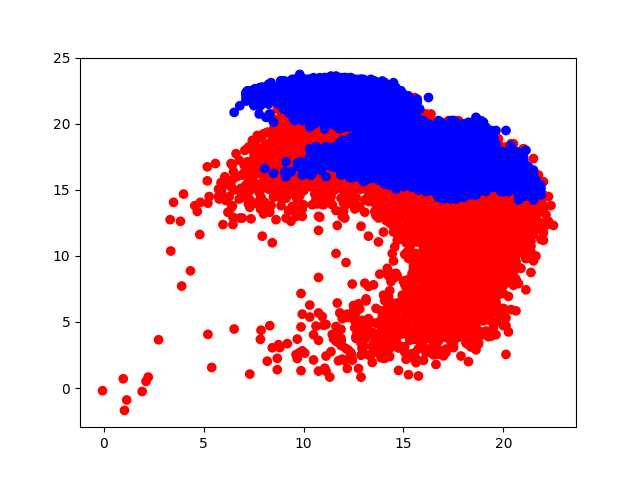

In [11]:
plt.clf()
plt.scatter(xs, ys, c=colors)
plt.show()

## PCA

In [12]:
import numpy as np
from sklearn.decomposition import KernelPCA, PCA

In [13]:
positive_points = get_points("positive", tags)
negative_points = get_points("negative", tags)

# p_pca = KernelPCA(n_components=2, kernel="cosine")
# n_pca = KernelPCA(n_components=2, kernel="cosine")
p_pca = PCA(n_components=3)
n_pca = PCA(n_components=3)

positive_points_t = p_pca.fit_transform(np.array(positive_points))
negative_points_t = n_pca.fit_transform(np.array(negative_points))

In [14]:
positive_xs, positive_ys, positive_zs = zip(*positive_points_t)
negative_xs, negative_ys, negative_zs = zip(*negative_points_t)

xs = negative_xs + positive_xs
ys = negative_ys + positive_ys
zs = negative_zs + positive_zs
colors = [[1,0,0,0.5]]*len(negative_xs) + [[0,0,1,0.5]]*len(positive_xs)


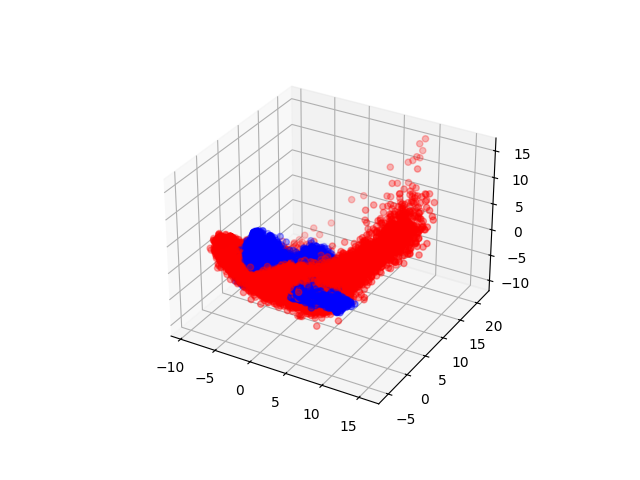

In [15]:
plt.clf()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs=zs, zdir='z', c=colors)
plt.show()

## TSNE

In [16]:
import numpy as np
from sklearn.manifold import TSNE

In [17]:
positive_points = get_points("positive", tags, limit=10_000)
negative_points = get_points("negative", tags, limit=10_000)

p_pca = TSNE(n_components=3, n_jobs=8)
n_pca = TSNE(n_components=3, n_jobs=8)

positive_points_t = p_pca.fit_transform(np.array(positive_points))
negative_points_t = n_pca.fit_transform(np.array(negative_points))

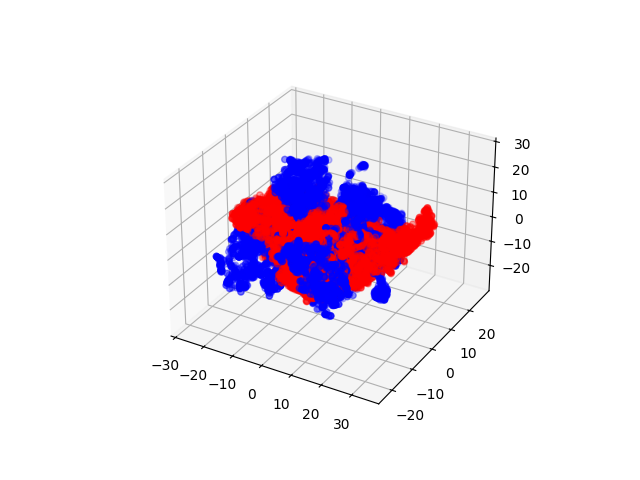

In [18]:
positive_xs, positive_ys, positive_zs = zip(*positive_points_t)
negative_xs, negative_ys, negative_zs = zip(*negative_points_t)

xs = negative_xs + positive_xs
ys = negative_ys + positive_ys
zs = negative_zs + positive_zs
colors = [[1,0,0,0.5]]*len(negative_xs) + [[0,0,1,0.5]]*len(positive_xs)

plt.clf()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs=zs, zdir='z', c=colors)
plt.show()